In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import math
from sklearn import linear_model
from sklearn.preprocessing import normalize
from scipy.stats import ttest_1samp
from scipy import stats

In [2]:
plt.rcParams['figure.dpi'] = 300
set_matplotlib_formats('retina')
sns.set(color_codes = True)
sns.set_context(rc={'lines.markeredgewidth': 1})
sns.set(font_scale=0.5)
plt.rcParams["font.family"] = "Carlito"

# LR for opportunities

## 1. Exclude Webster from cities

In [3]:
data_dir = 'info_total_with_class.csv'

r_data = pd.read_csv(data_dir)
# drop rows, the city column of which has NaN
valid_cities = r_data.dropna(subset=['dim_loc_city'])
# exclude any rows containing city name 'webster'
valid_data = valid_cities[~(valid_cities['dim_loc_city'].str.lower().str.contains('webster'))]
# .drop(['slope', 'intercept'], axis = 1)

## 2. Xerox model ppm distribution

In [4]:
# xerox_model = valid_data[valid_data['dim_model_manf_nm'].str.lower().str.contains('xerox')]
# xerox_model.head(3)

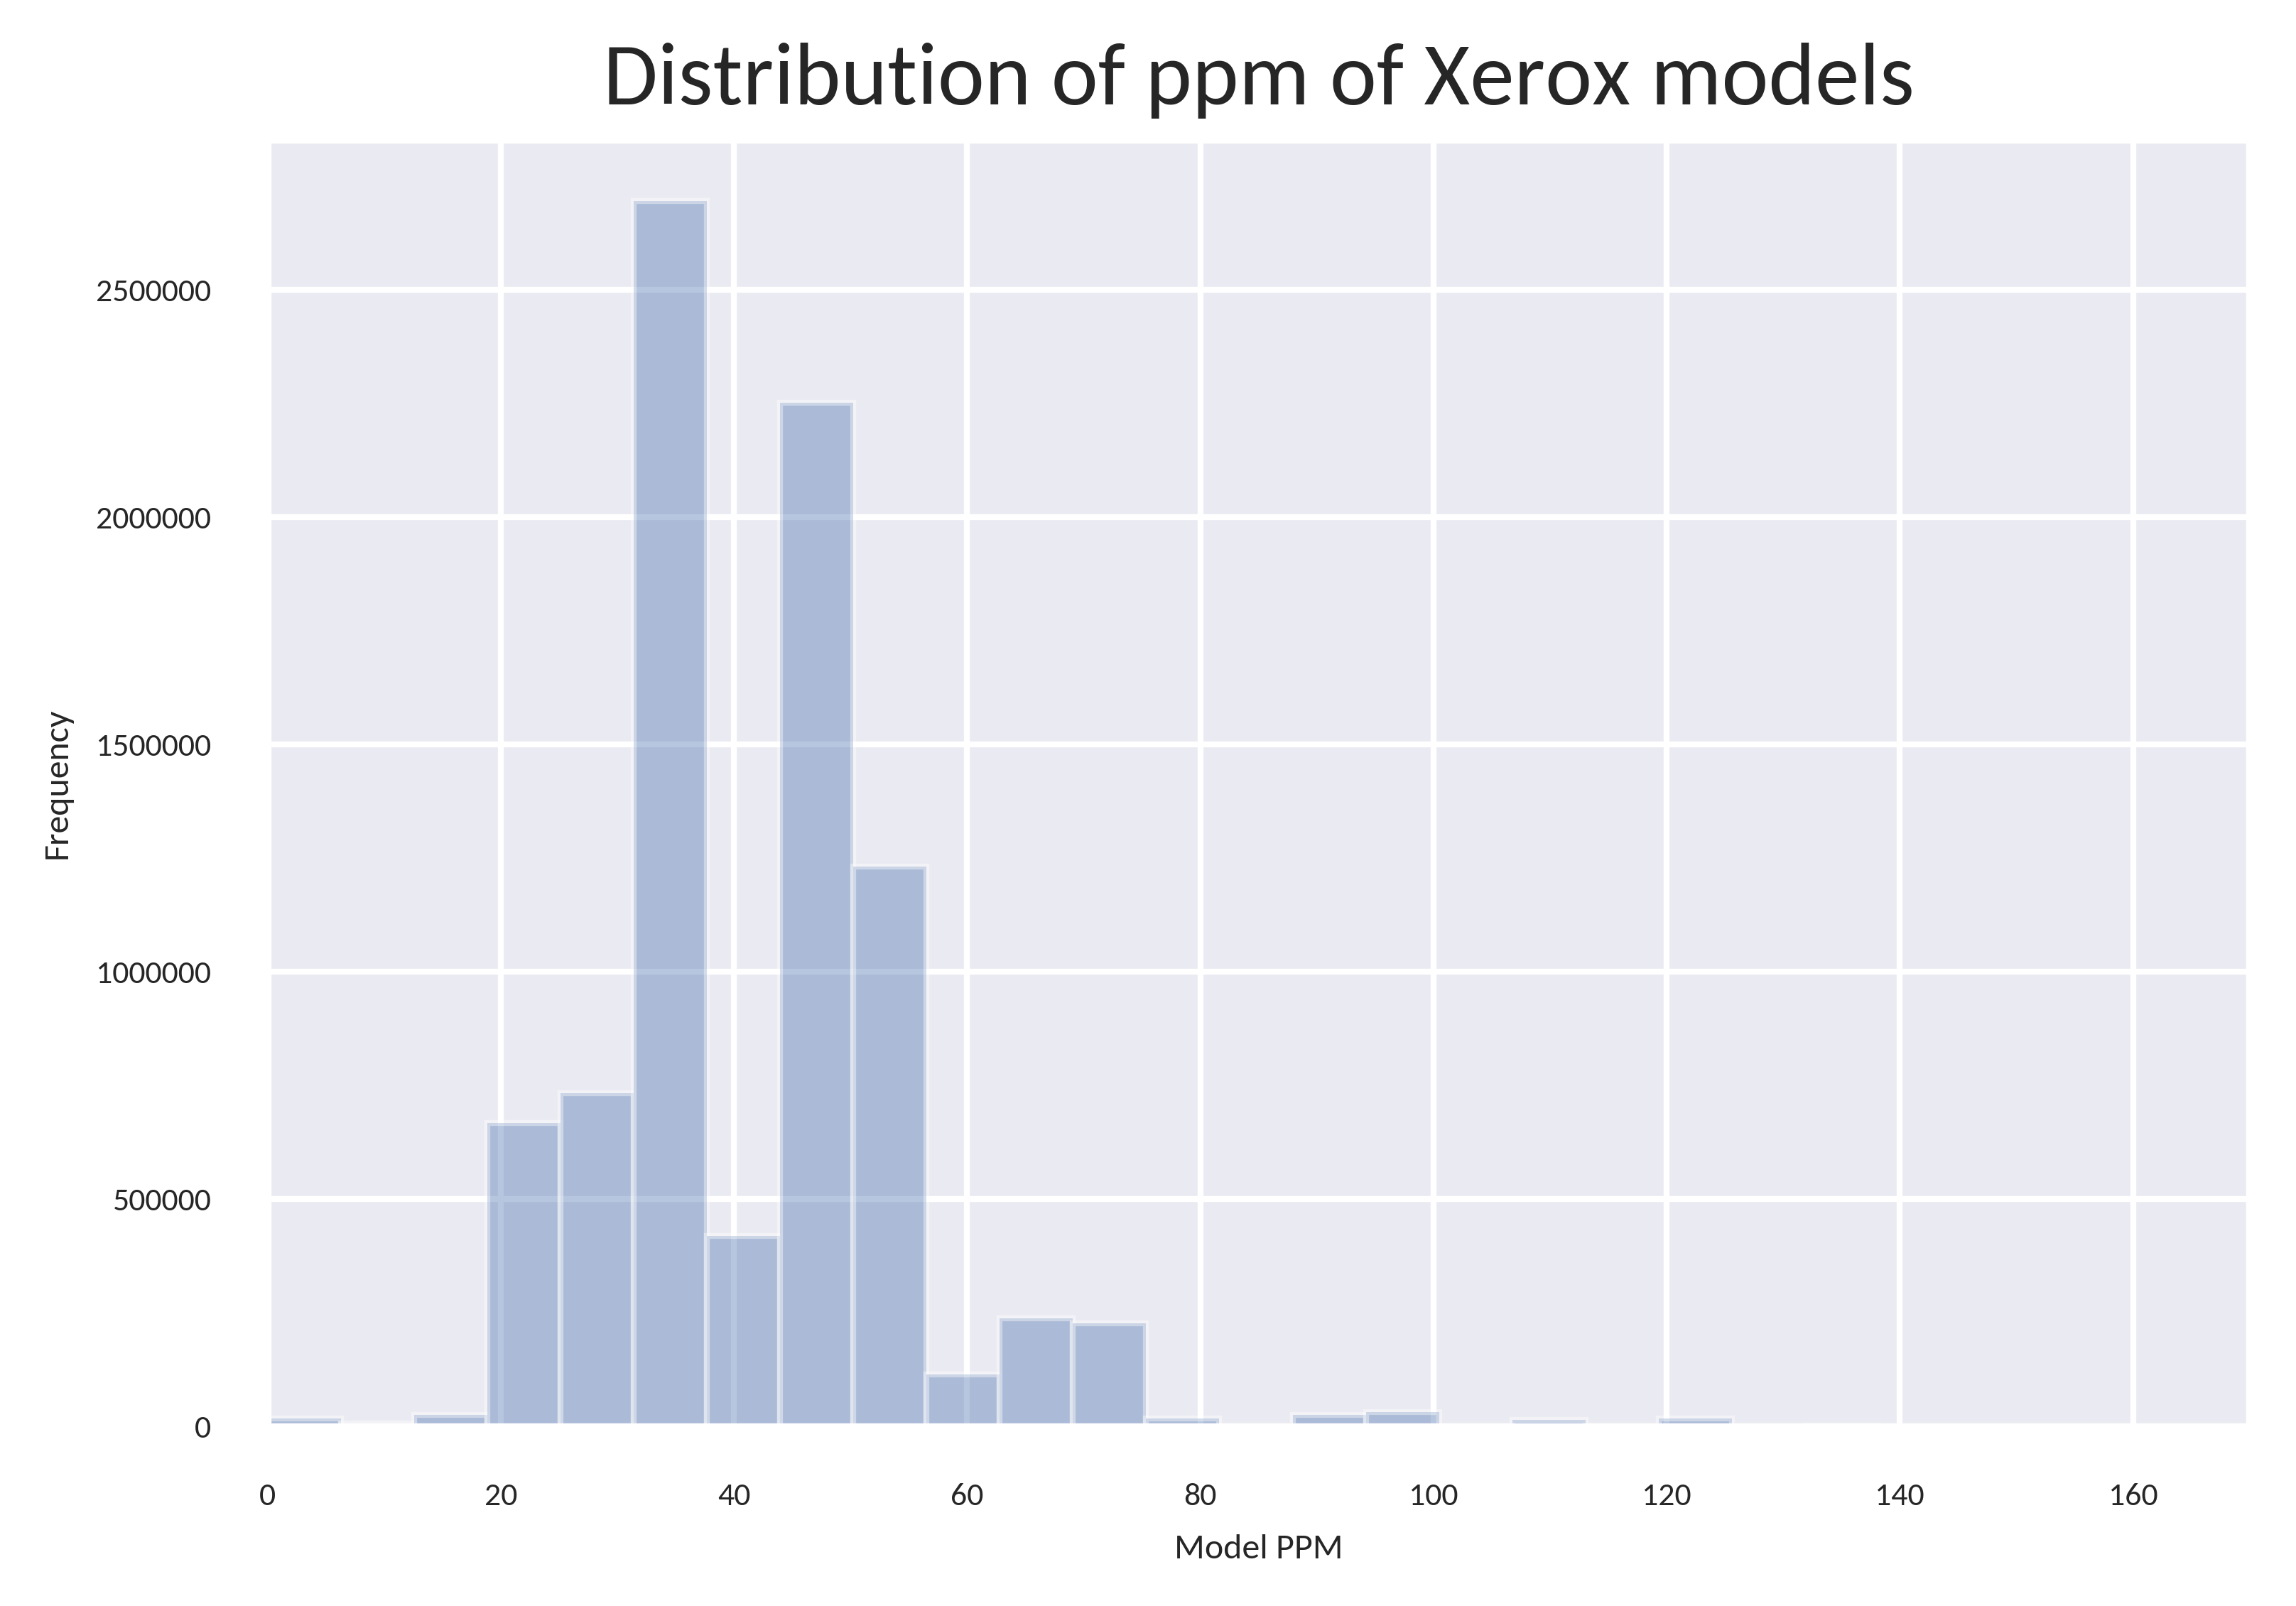

In [6]:
# sns.distplot(xerox_model.dim_model_ppm[xerox_model.dim_model_ppm != 10016.0], bins = 50, kde = False)
# plt.xlim([0, 170])
# plt.xlabel('Model PPM')
# plt.ylabel('Frequency')
# plt.title('Distribution of ppm of Xerox models', fontsize = 15)
# plt.show()

In [7]:
# # percentage of assets based on ppm
# ppm_data = xerox_model.dim_model_ppm.values
# len(np.where((ppm_data >= 20) & (ppm_data <= 150))[0])/len(ppm_data)

0.9940054515859206

## 3. Opportunities and abnormal

In [51]:
# append slopes to accounts
def appendSlopes(valid_in, color):
    valid_in_mon = valid_in.groupby(['dim_acct_sk', 'month'])[color].sum().reset_index()
    valid_in_acct = valid_in_mon.groupby('dim_acct_sk')[color].sum().reset_index()
    
    _ids = set(valid_in_acct.dim_acct_sk.values)
    slopes = []
    p_val = []

    for _id in _ids:
        temp_df = valid_in_mon[valid_in_mon.dim_acct_sk == _id]
        response = np.zeros(12)
        response[temp_df['month']-1] = temp_df[color].values
        if np.any(response):
            response = (response - np.mean(response))/np.std(response)

    #     regr = linear_model.LinearRegression()
            lm = stats.linregress(np.arange(1,13), response)
            slopes.append(lm.slope)
            p_val.append(lm.pvalue)
        else:
            slopes.append(0)
            p_val.append(1)

    valid_in_acct['slopes'] = slopes
    valid_in_acct['p-value'] = p_val

    return valid_in_acct

In [52]:
# in scope data
valid_in = valid_data[valid_data.dim_asset_inscope == 1]
# out of scope data
valid_out = valid_data[valid_data.dim_asset_inscope == 0]
# devide the data based on their color and scope attributes
valid_in_slopes_bw = appendSlopes(valid_in, 'BlackVolume')
valid_in_slopes_color = appendSlopes(valid_in, 'ColorVolume')
valid_out_slopes_bw = appendSlopes(valid_out, 'BlackVolume')
valid_out_slopes_color = appendSlopes(valid_out, 'ColorVolume')

In [11]:
# # saving the files
# valid_in_slopes_bw.to_csv('/public/ywu82/Slopes/in_scope_bw.csv', index=False)
# valid_in_slopes_color.to_csv('/public/ywu82/Slopes/in_scope_color.csv', index=False)
# valid_out_slopes_bw.to_csv('/public/ywu82/Slopes/out_of_scope_bw.csv', index=False)
# valid_out_slopes_color.to_csv('/public/ywu82/Slopes/out_of_scope_color.csv', index=False)

### 3.1 accounts with problems

#### 3.1.1 In scope abnormal black and white

In [53]:
# bw_problem = valid_in_slopes_bw[(valid_in_slopes_bw.slopes <0) & (valid_in_slopes_bw['p-value'] < 0.05) & (valid_in_slopes_bw.BlackVolume >= 1.0e7)]
bw_problem = valid_in_slopes_bw[(valid_in_slopes_bw.slopes <0) & (valid_in_slopes_bw['p-value'] < 0.05)]
bw_problem_list = bw_problem.dim_acct_sk.values
print('The number of abnormal black volume accounts is: %d'%len(bw_problem_list))

The number of abnormal black volume accounts is: 259


In [54]:
# the black account which decreased the most last year
bw_problem[bw_problem.slopes == min(bw_problem.slopes)]

,dim_acct_sk,BlackVolume,slopes,p-value
517,2818,866101.0,-0.280447,2.458778e-07


#### 3.1.2 In scope abnormal color

In [55]:
# color_problem = valid_in_slopes_color[(valid_in_slopes_color['p-value'] < 0.05) & (valid_in_slopes_color.ColorVolume > 1.0e6) & (valid_in_slopes_color.slopes < 0)]
color_problem = valid_in_slopes_color[(valid_in_slopes_color['p-value'] < 0.05) & (valid_in_slopes_color.slopes < 0)]
color_problem_list = color_problem.dim_acct_sk.values
print('The number of abnormal black volume accounts is: %d'%len(color_problem_list))

The number of abnormal black volume accounts is: 220


In [56]:
# the color account which decreased the most last year
color_problem[color_problem.slopes == min(color_problem.slopes)]

,dim_acct_sk,ColorVolume,slopes,p-value
115,1236,471489.0,-0.28103,1.780717e-07


#### 3.1.3 plot the accounts that decreased most

In [11]:
# black in scope groupby account and month
bw_ = valid_in.groupby(['dim_acct_sk', 'month'])['BlackVolume'].sum().reset_index()

# color in scope groupby account and month
color_ = valid_in.groupby(['dim_acct_sk', 'month'])['ColorVolume'].sum().reset_index()

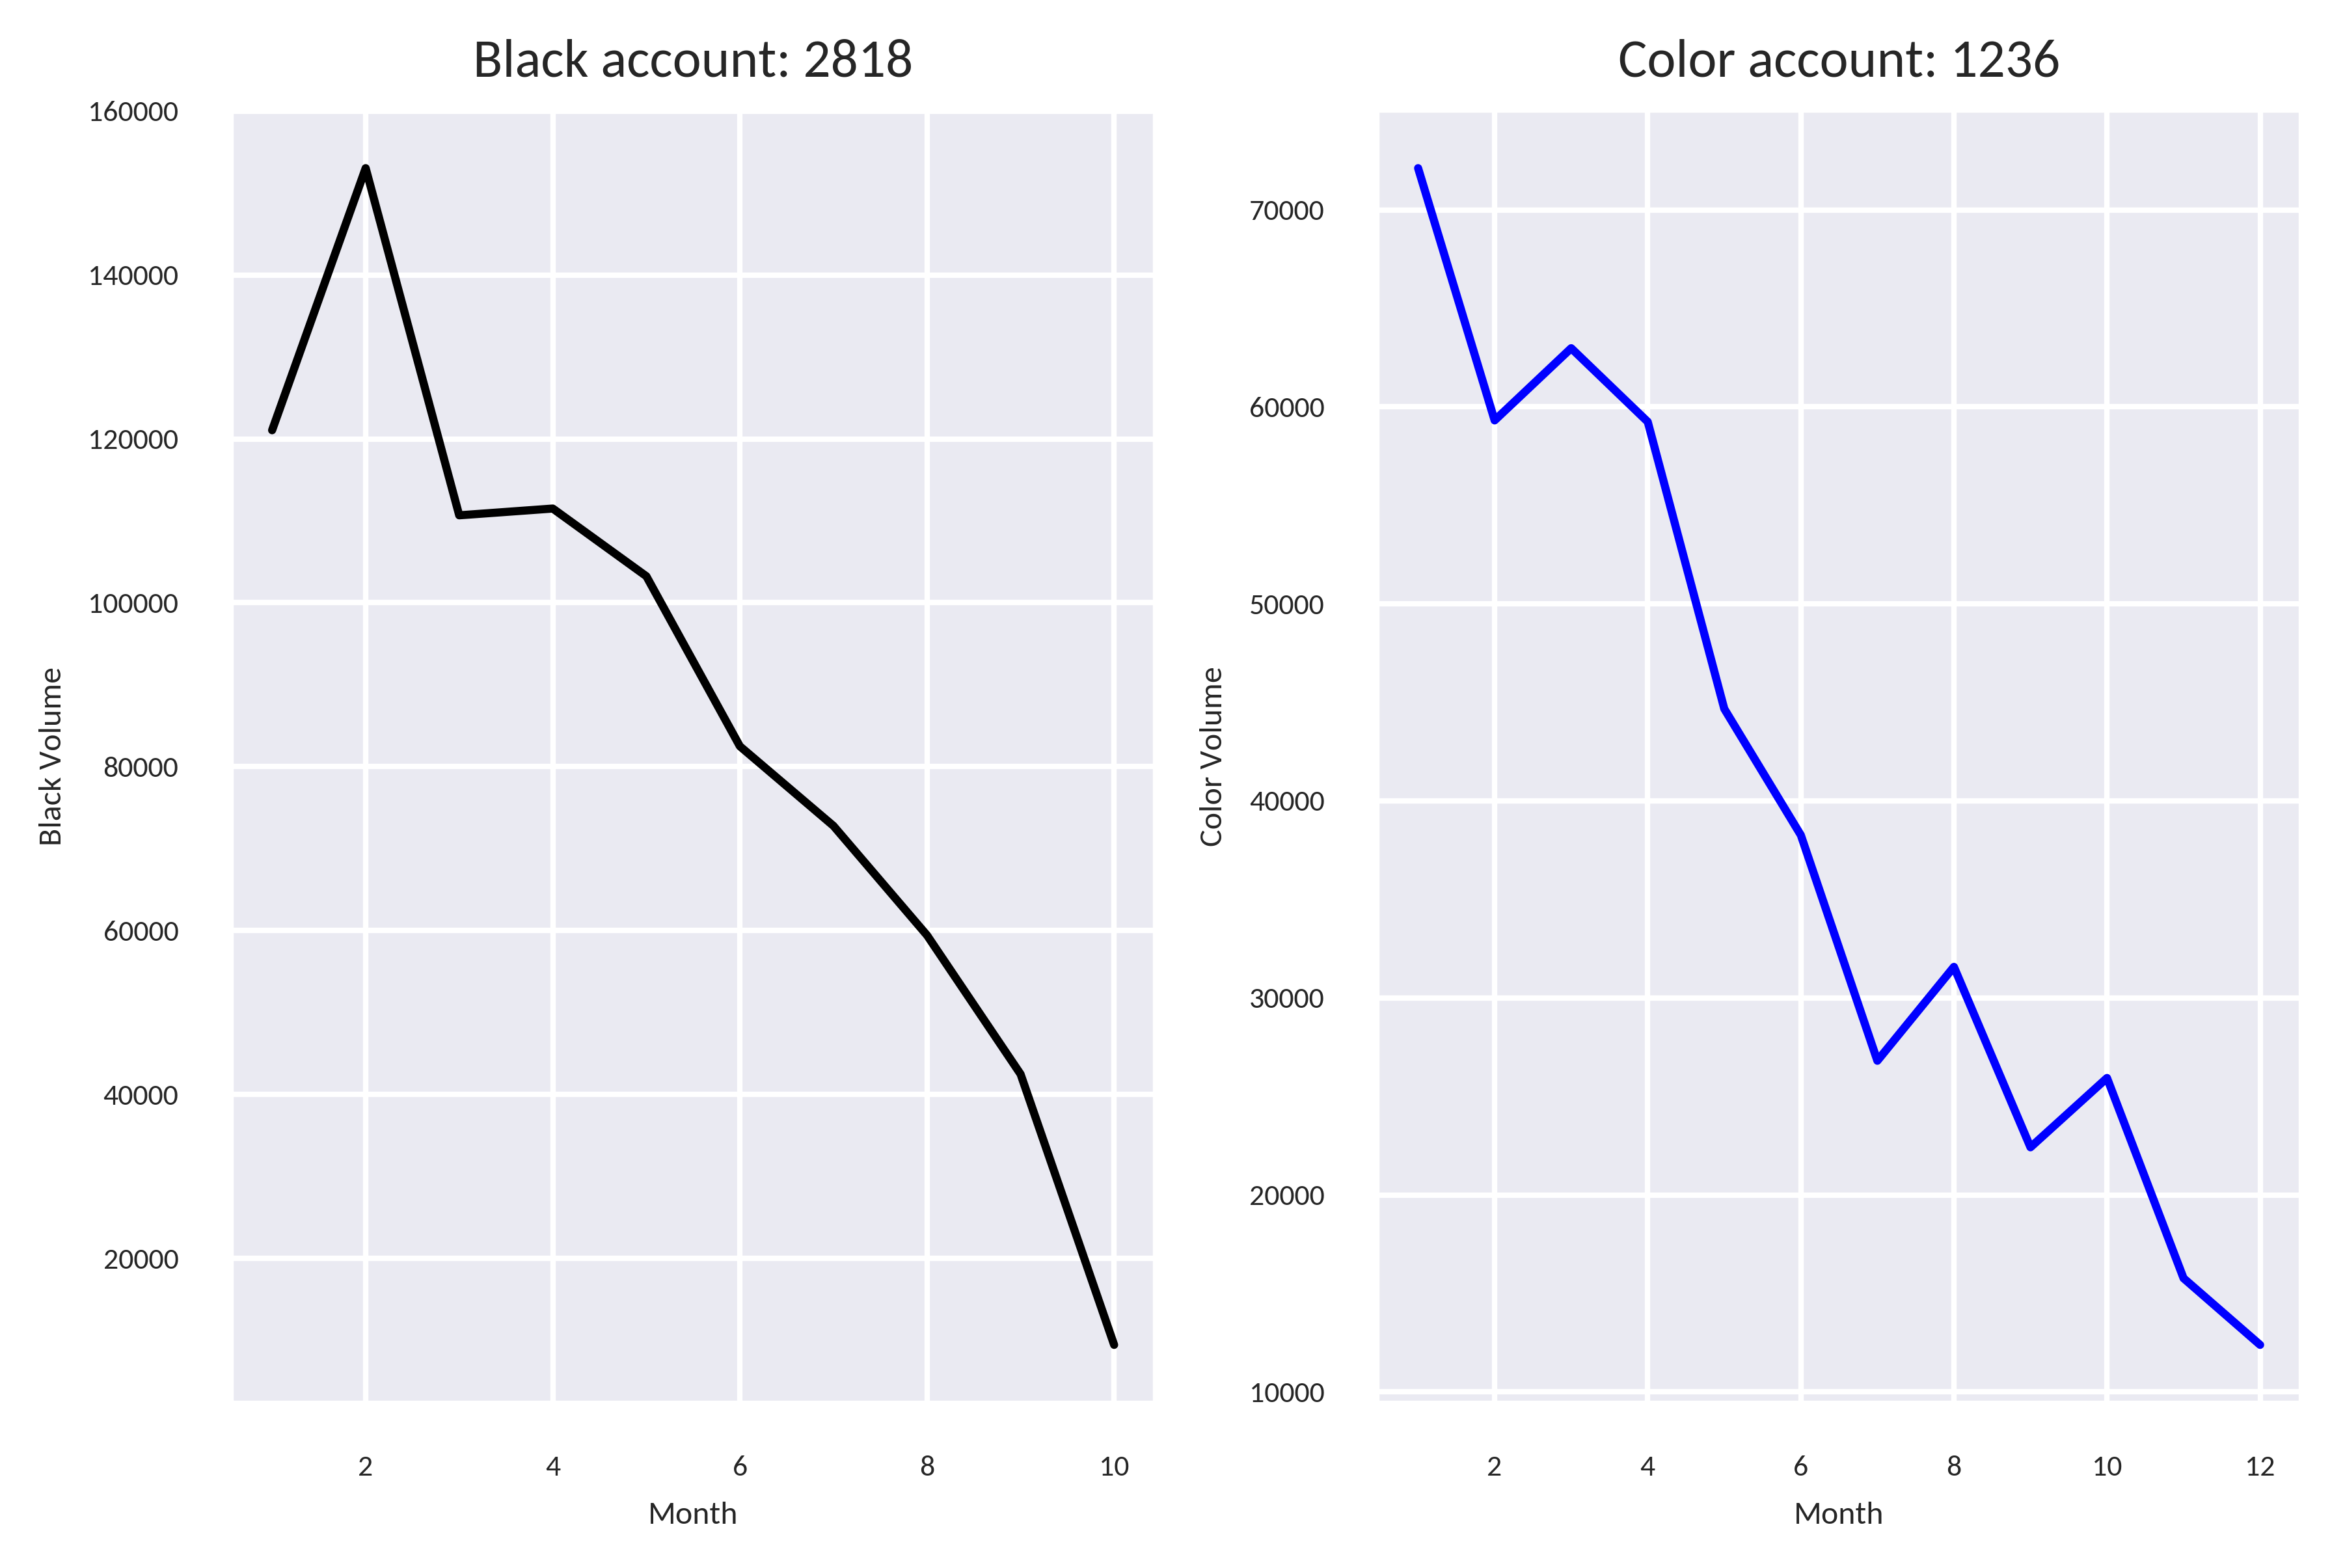

In [12]:
plt.subplot(1,2,1)
plt.plot(bw_[bw_.dim_acct_sk == 2818]['month'], bw_[bw_.dim_acct_sk == 2818]['BlackVolume'], color = 'black')
# plt.xticks(range(1,13))
plt.xlabel('Month')
plt.ylabel('Black Volume')
plt.title('Black account: 2818', fontsize = 10)

plt.subplot(1,2,2)
plt.plot(color_[color_.dim_acct_sk == 1236]['month'], color_[color_.dim_acct_sk == 1236]['ColorVolume'], color = 'blue')
# plt.xticks(range(1,13))
plt.xlabel('Month')
plt.ylabel('Color Volume')
plt.title('Color account: 1236', fontsize = 10)

plt.tight_layout()
plt.show()

#### 3.1.4 intersection of black and color accounts

In [13]:
# intersection of black and color problems
len(np.intersect1d(color_problem.dim_acct_sk.values, bw_problem.dim_acct_sk.values))

87

### 3.2 accounts with opportunities

#### 3.2.1 Out of scope opportunity black and white

In [57]:
# black and white with significant positive slopes

def truePotential(valid_out_slopes_bw, valid_in_slopes_bw):
    bw_opp = valid_out_slopes_bw[(valid_out_slopes_bw.slopes >0) & (valid_out_slopes_bw['p-value'] < 0.05)]
    bw_opp_list = bw_opp.dim_acct_sk.values

    # accounts of in scope black and white without significant changes
    bw_no_ch = valid_in_slopes_bw[valid_in_slopes_bw['p-value'] >= 0.05].dim_acct_sk.values
    true_bw_opp = [i for i in bw_opp_list if i in bw_no_ch]
    return true_bw_opp

In [58]:
true_bw_opp = truePotential(valid_out_slopes_bw, valid_in_slopes_bw)
print('The number of black accounts with true growth potential is: %d'%len(true_bw_opp))

The number of black accounts with true growth potential is: 116


#### 3.2.2 Out of scope opportunity color

In [59]:
true_col_opp = truePotential(valid_out_slopes_color, valid_in_slopes_color)
print('The number of color accounts with true growth potential is: %d'%len(true_col_opp))

The number of color accounts with true growth potential is: 113


#### 3.2.3 intersection of black and color accounts with potential

In [18]:
len(np.intersect1d(true_bw_opp, true_col_opp))

20

#### 3.2.4 plot of black and color accounts with potential

In [19]:
# out of scope groupby account and month
color_out = valid_out.groupby(['dim_acct_sk', 'month'])['ColorVolume'].sum().reset_index()
# out of scope groupby account and month
bw_out = valid_out.groupby(['dim_acct_sk', 'month'])['BlackVolume'].sum().reset_index()

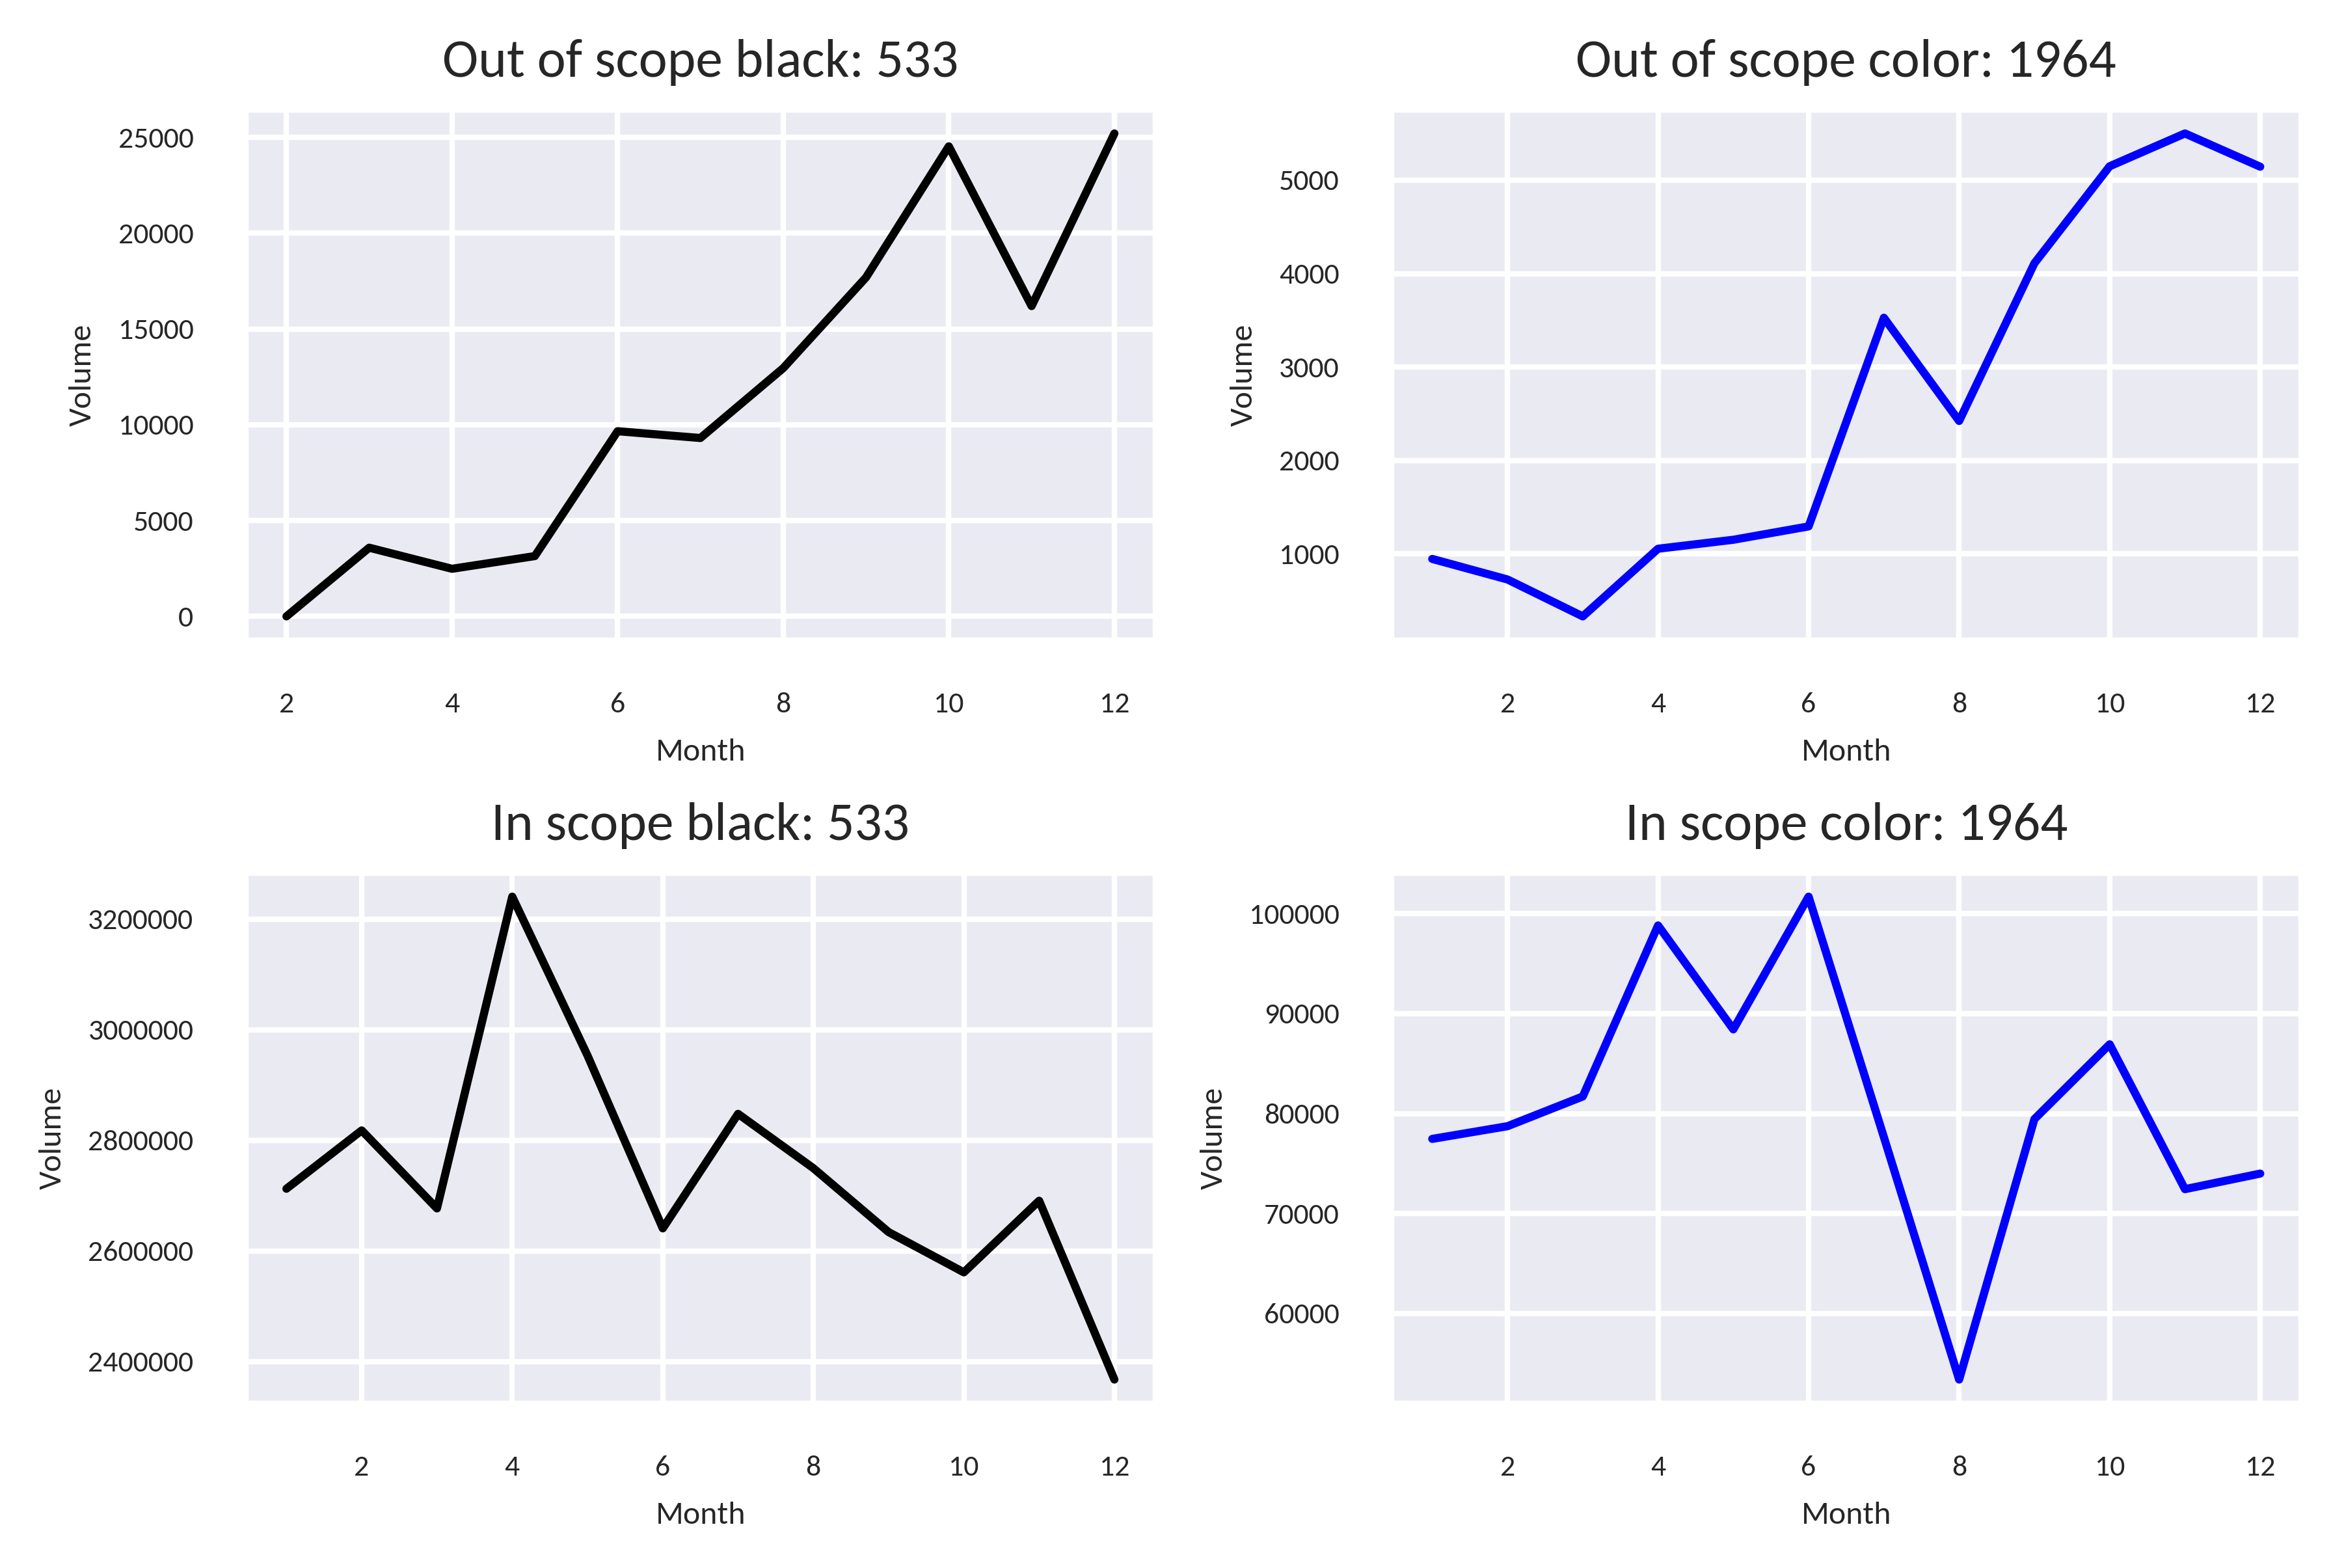

In [20]:
plt.subplot(2,2,1)
plt.plot(bw_out[bw_out.dim_acct_sk == 533].month, bw_out[bw_out.dim_acct_sk == 533].BlackVolume, color='black')
plt.ticklabel_format(style='sci', axis='y')
plt.xlabel('Month')
plt.ylabel('Volume')
plt.title('Out of scope black: 533', fontsize = 10)

plt.subplot(2,2,2)
plt.plot(color_out[color_out.dim_acct_sk == 1964].month, color_out[color_out.dim_acct_sk == 1964].ColorVolume, color='blue')
plt.ticklabel_format(style='sci', axis='y')
plt.xlabel('Month')
plt.ylabel('Volume')
plt.title('Out of scope color: 1964', fontsize = 10)

plt.subplot(2,2,3)
plt.plot(bw_[bw_.dim_acct_sk == 533].month, bw_[bw_.dim_acct_sk == 533].BlackVolume, color = 'black')
plt.ticklabel_format(style='sci', axis='y')
plt.xlabel('Month')
plt.ylabel('Volume')
plt.title('In scope black: 533', fontsize = 10)

plt.subplot(2,2,4)
plt.plot(color_[color_.dim_acct_sk == 1964].month, color_[color_.dim_acct_sk == 1964].ColorVolume, color='blue')
plt.ticklabel_format(style='sci', axis='y')
plt.xlabel('Month')
plt.ylabel('Volume')
plt.title('In scope color: 1964', fontsize = 10)

plt.tight_layout()
plt.show()

### 3.3 ppm distribution of accounts with opportunities

In [39]:
ppm_dict = {}
ppm_dict2 = {}

for i in true_bw_opp:
    temp_df = valid_out[valid_out.dim_acct_sk == i].groupby('dim_model_ppm')['dim_asset_sk'].count().reset_index()
    for i in range(len(temp_df.dim_model_ppm.values)):
        ppm_dict[temp_df.dim_model_ppm.values[i]] = ppm_dict.get(temp_df.dim_model_ppm.values[i], 0) + temp_df.dim_asset_sk.values[i]
        
for i in true_col_opp:
    temp_df = valid_out[valid_out.dim_acct_sk == i].groupby('dim_model_ppm')['dim_asset_sk'].count().reset_index()
    for i in range(len(temp_df.dim_model_ppm.values)):
        ppm_dict2[temp_df.dim_model_ppm.values[i]] = ppm_dict2.get(temp_df.dim_model_ppm.values[i], 0) + temp_df.dim_asset_sk.values[i]

In [40]:
hist_data = []

for i in ppm_dict.keys():
    if i <= 200 and i > 0:
        hist_data += [i]*ppm_dict[i]
        
hist_data2 = []

for i in ppm_dict2.keys():
    if i <= 200 and i > 0:
        hist_data2 += [i]*ppm_dict2[i]

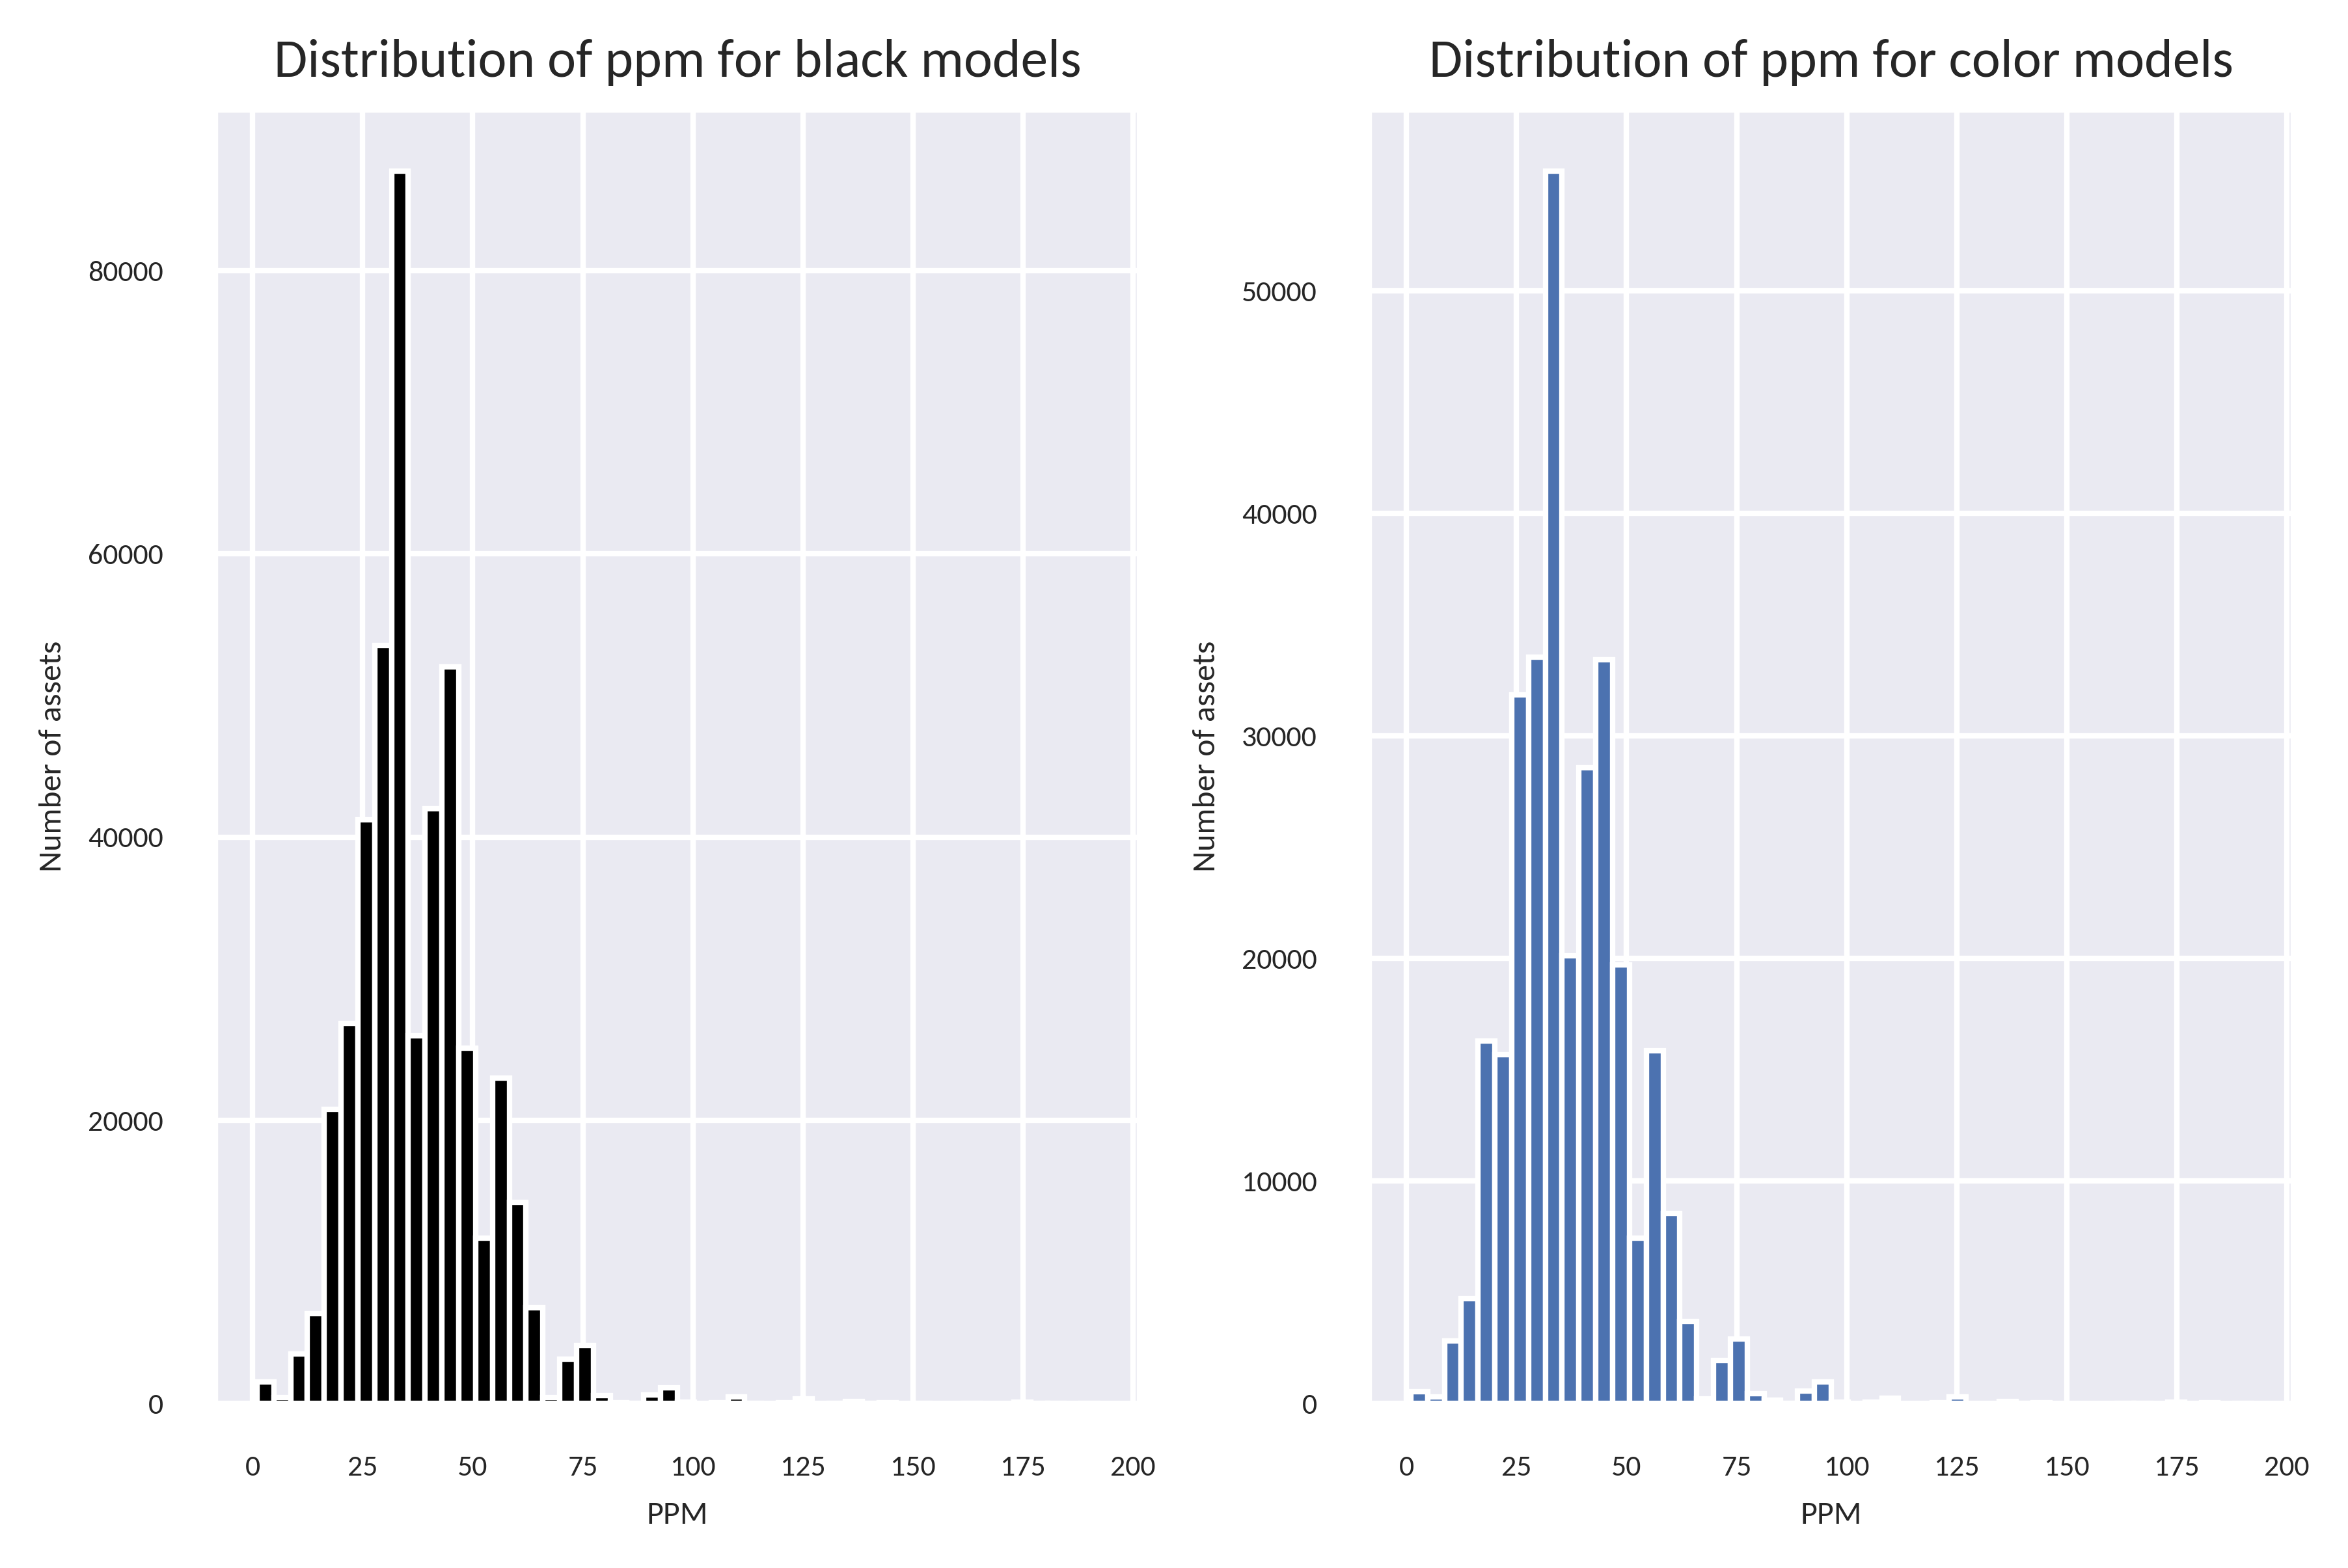

In [41]:
plt.subplot(1,2,1)
plt.hist(hist_data, bins = 50, color = 'black')
plt.xlabel('PPM')
plt.ylabel('Number of assets')
plt.title('Distribution of ppm for black models', fontsize = 10)

plt.subplot(1,2,2)
plt.hist(hist_data2, bins = 50)
plt.xlabel('PPM')
plt.ylabel('Number of assets')
plt.title('Distribution of ppm for color models', fontsize = 10)

plt.tight_layout()
plt.show()

In [42]:
len(np.where((np.array(hist_data)>=20) & (np.array(hist_data)<=150))[0])/len(np.where(np.array(hist_data) > 0)[0])

0.9507528673313762

In [43]:
len(np.where((np.array(hist_data2)>=20) & (np.array(hist_data2)<=150))[0])/len(np.where(np.array(hist_data2) > 0)[0])

0.9421128798842258

### 3.4 additional analysis of opportunities

In [46]:
def df2tables(valid_data, true_bw_opp):
    bw_opp_data = valid_data[valid_data.dim_acct_sk.isin(true_bw_opp)]
    location = bw_opp_data.country_iso3
    manuf = bw_opp_data.dim_model_manf_nm
    ppm = bw_opp_data.dim_model_ppm
    
    loc_stats = {}
    manuf_stats = {}
    
    for i in location:
        loc_stats[i] = loc_stats.get(i,0)+1
        
    for j in manuf:
        manuf_stats[j] = manuf_stats.get(j,0)+1
    
    return loc_stats, manuf_stats, ppm

In [70]:
loc_stats, manuf_stats, ppm = df2tables(valid_data, true_col_opp)

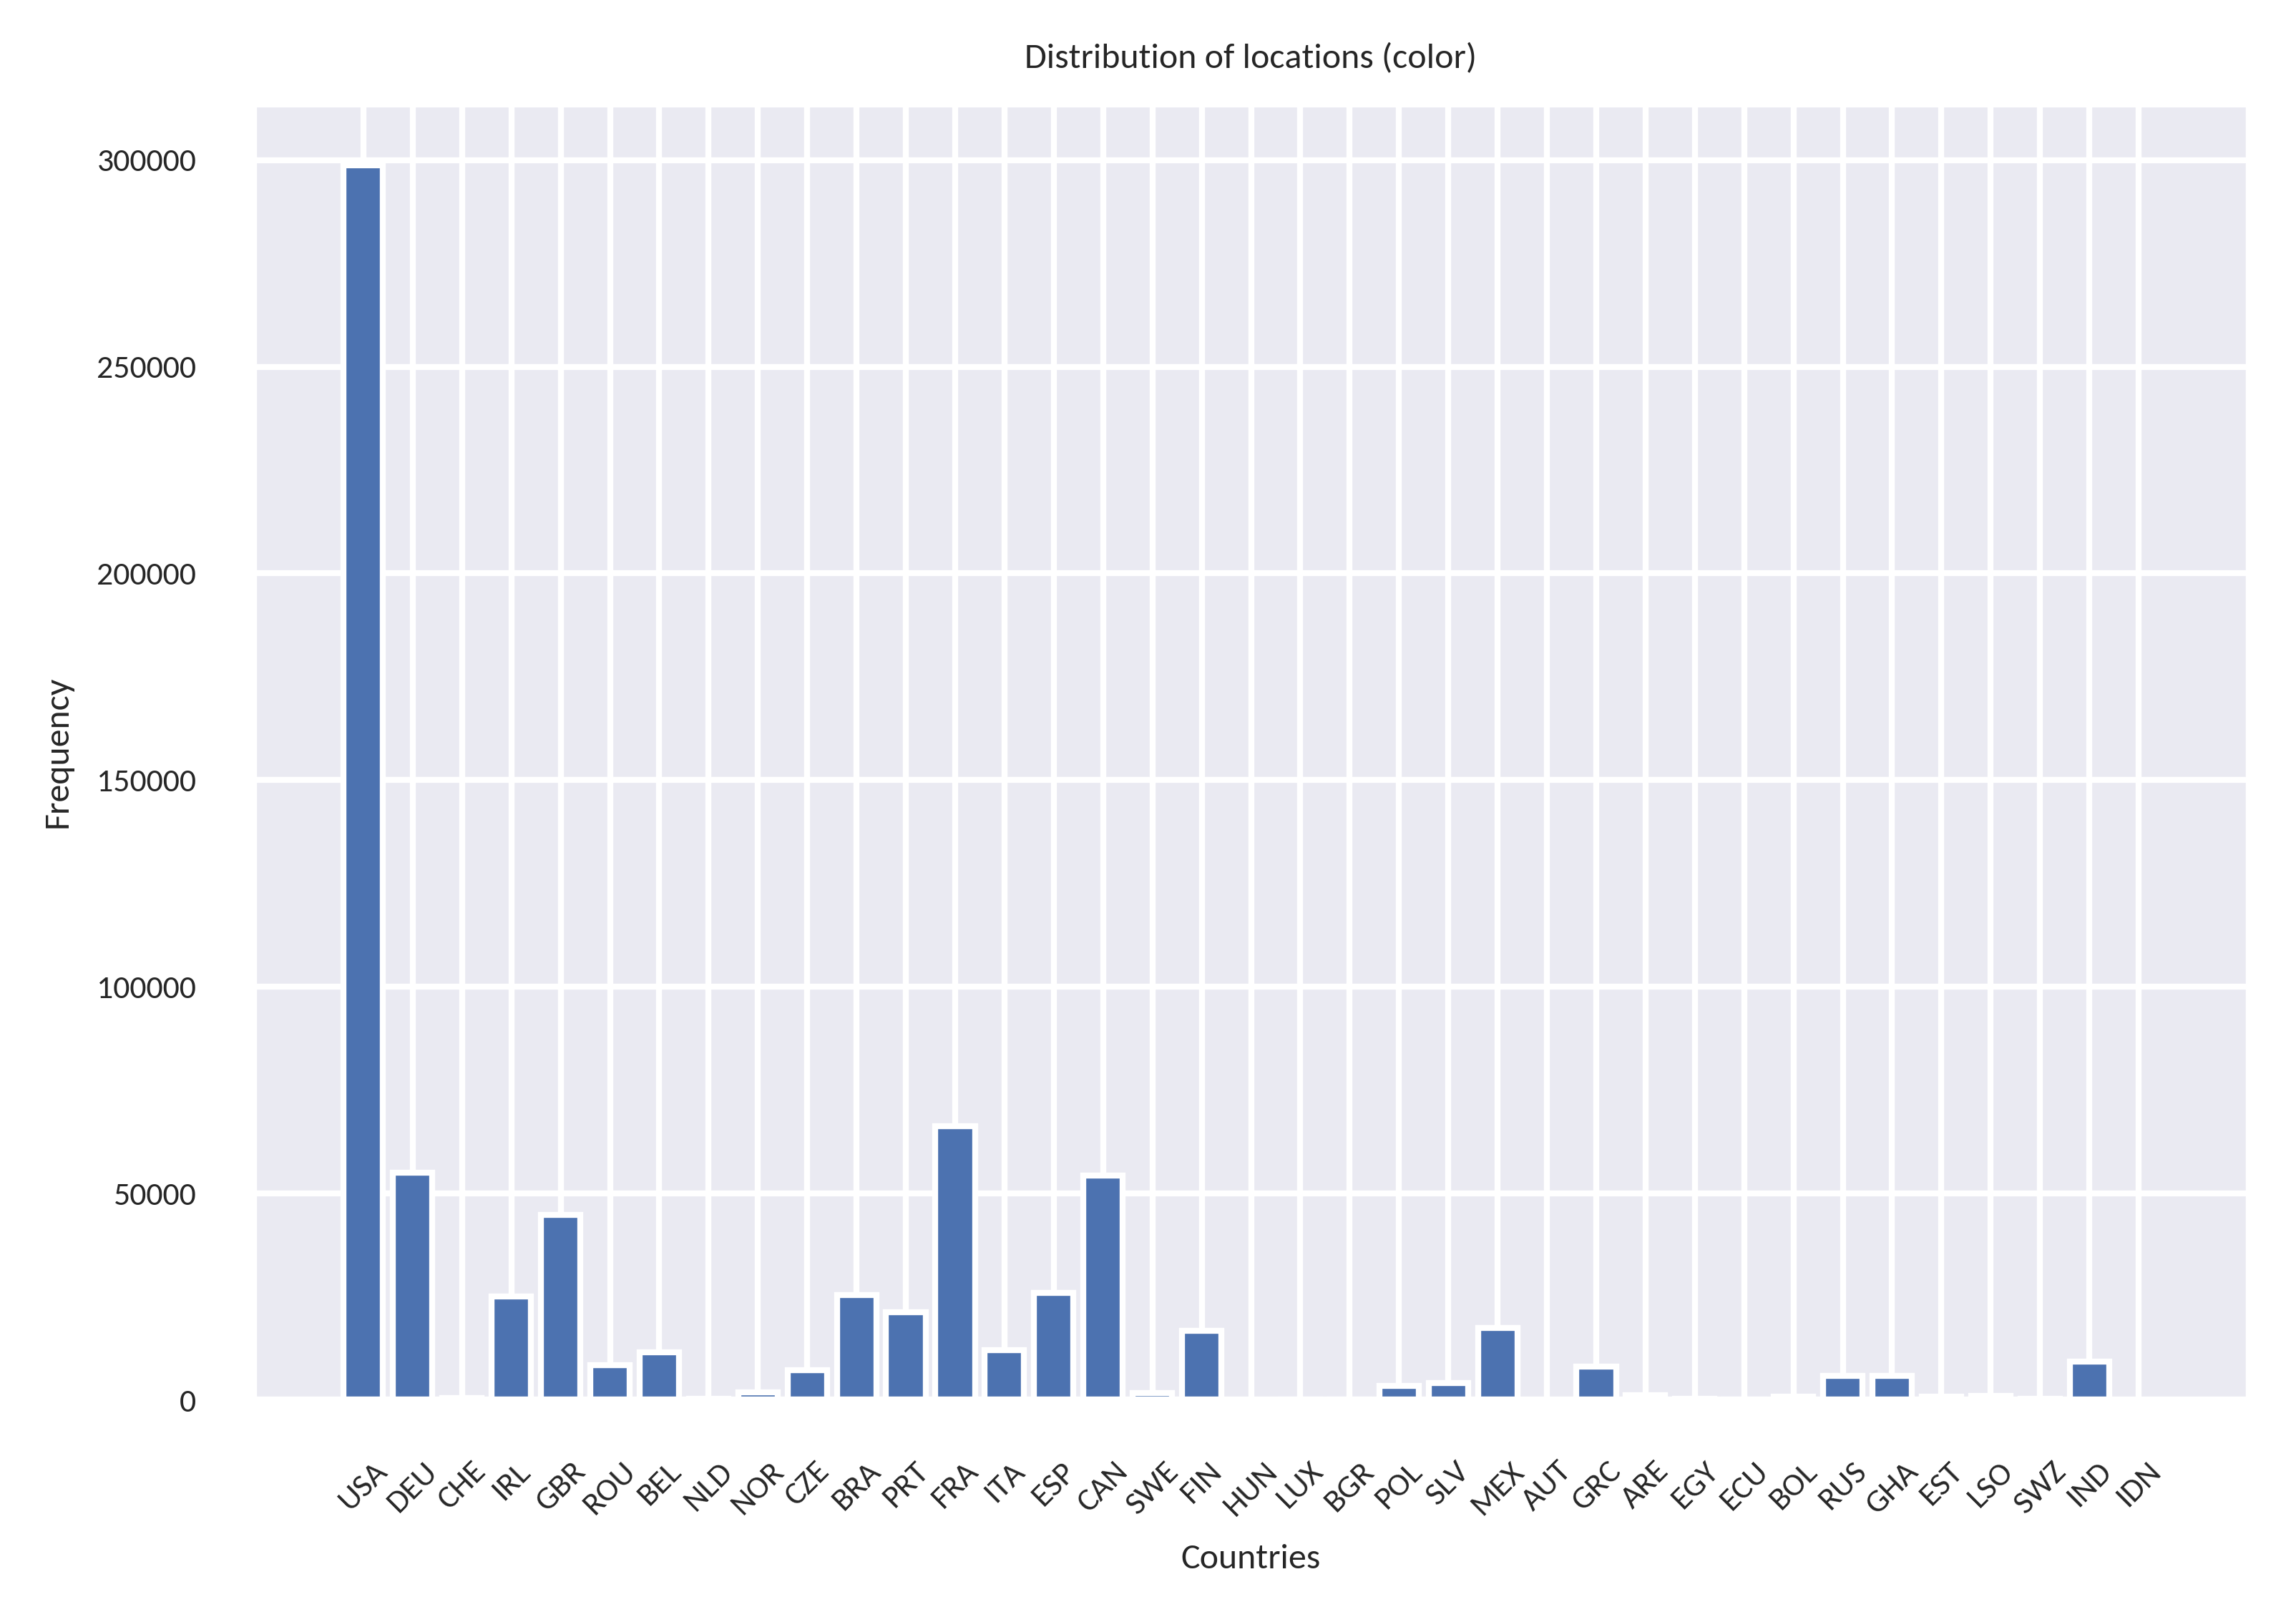

In [74]:
plt.bar(loc_stats.keys(), [loc_stats[i] for i in loc_stats.keys()])
plt.xticks(rotation=45)
plt.title('Distribution of locations (color)')
plt.xlabel('Countries')
plt.ylabel('Frequency')
plt.show()

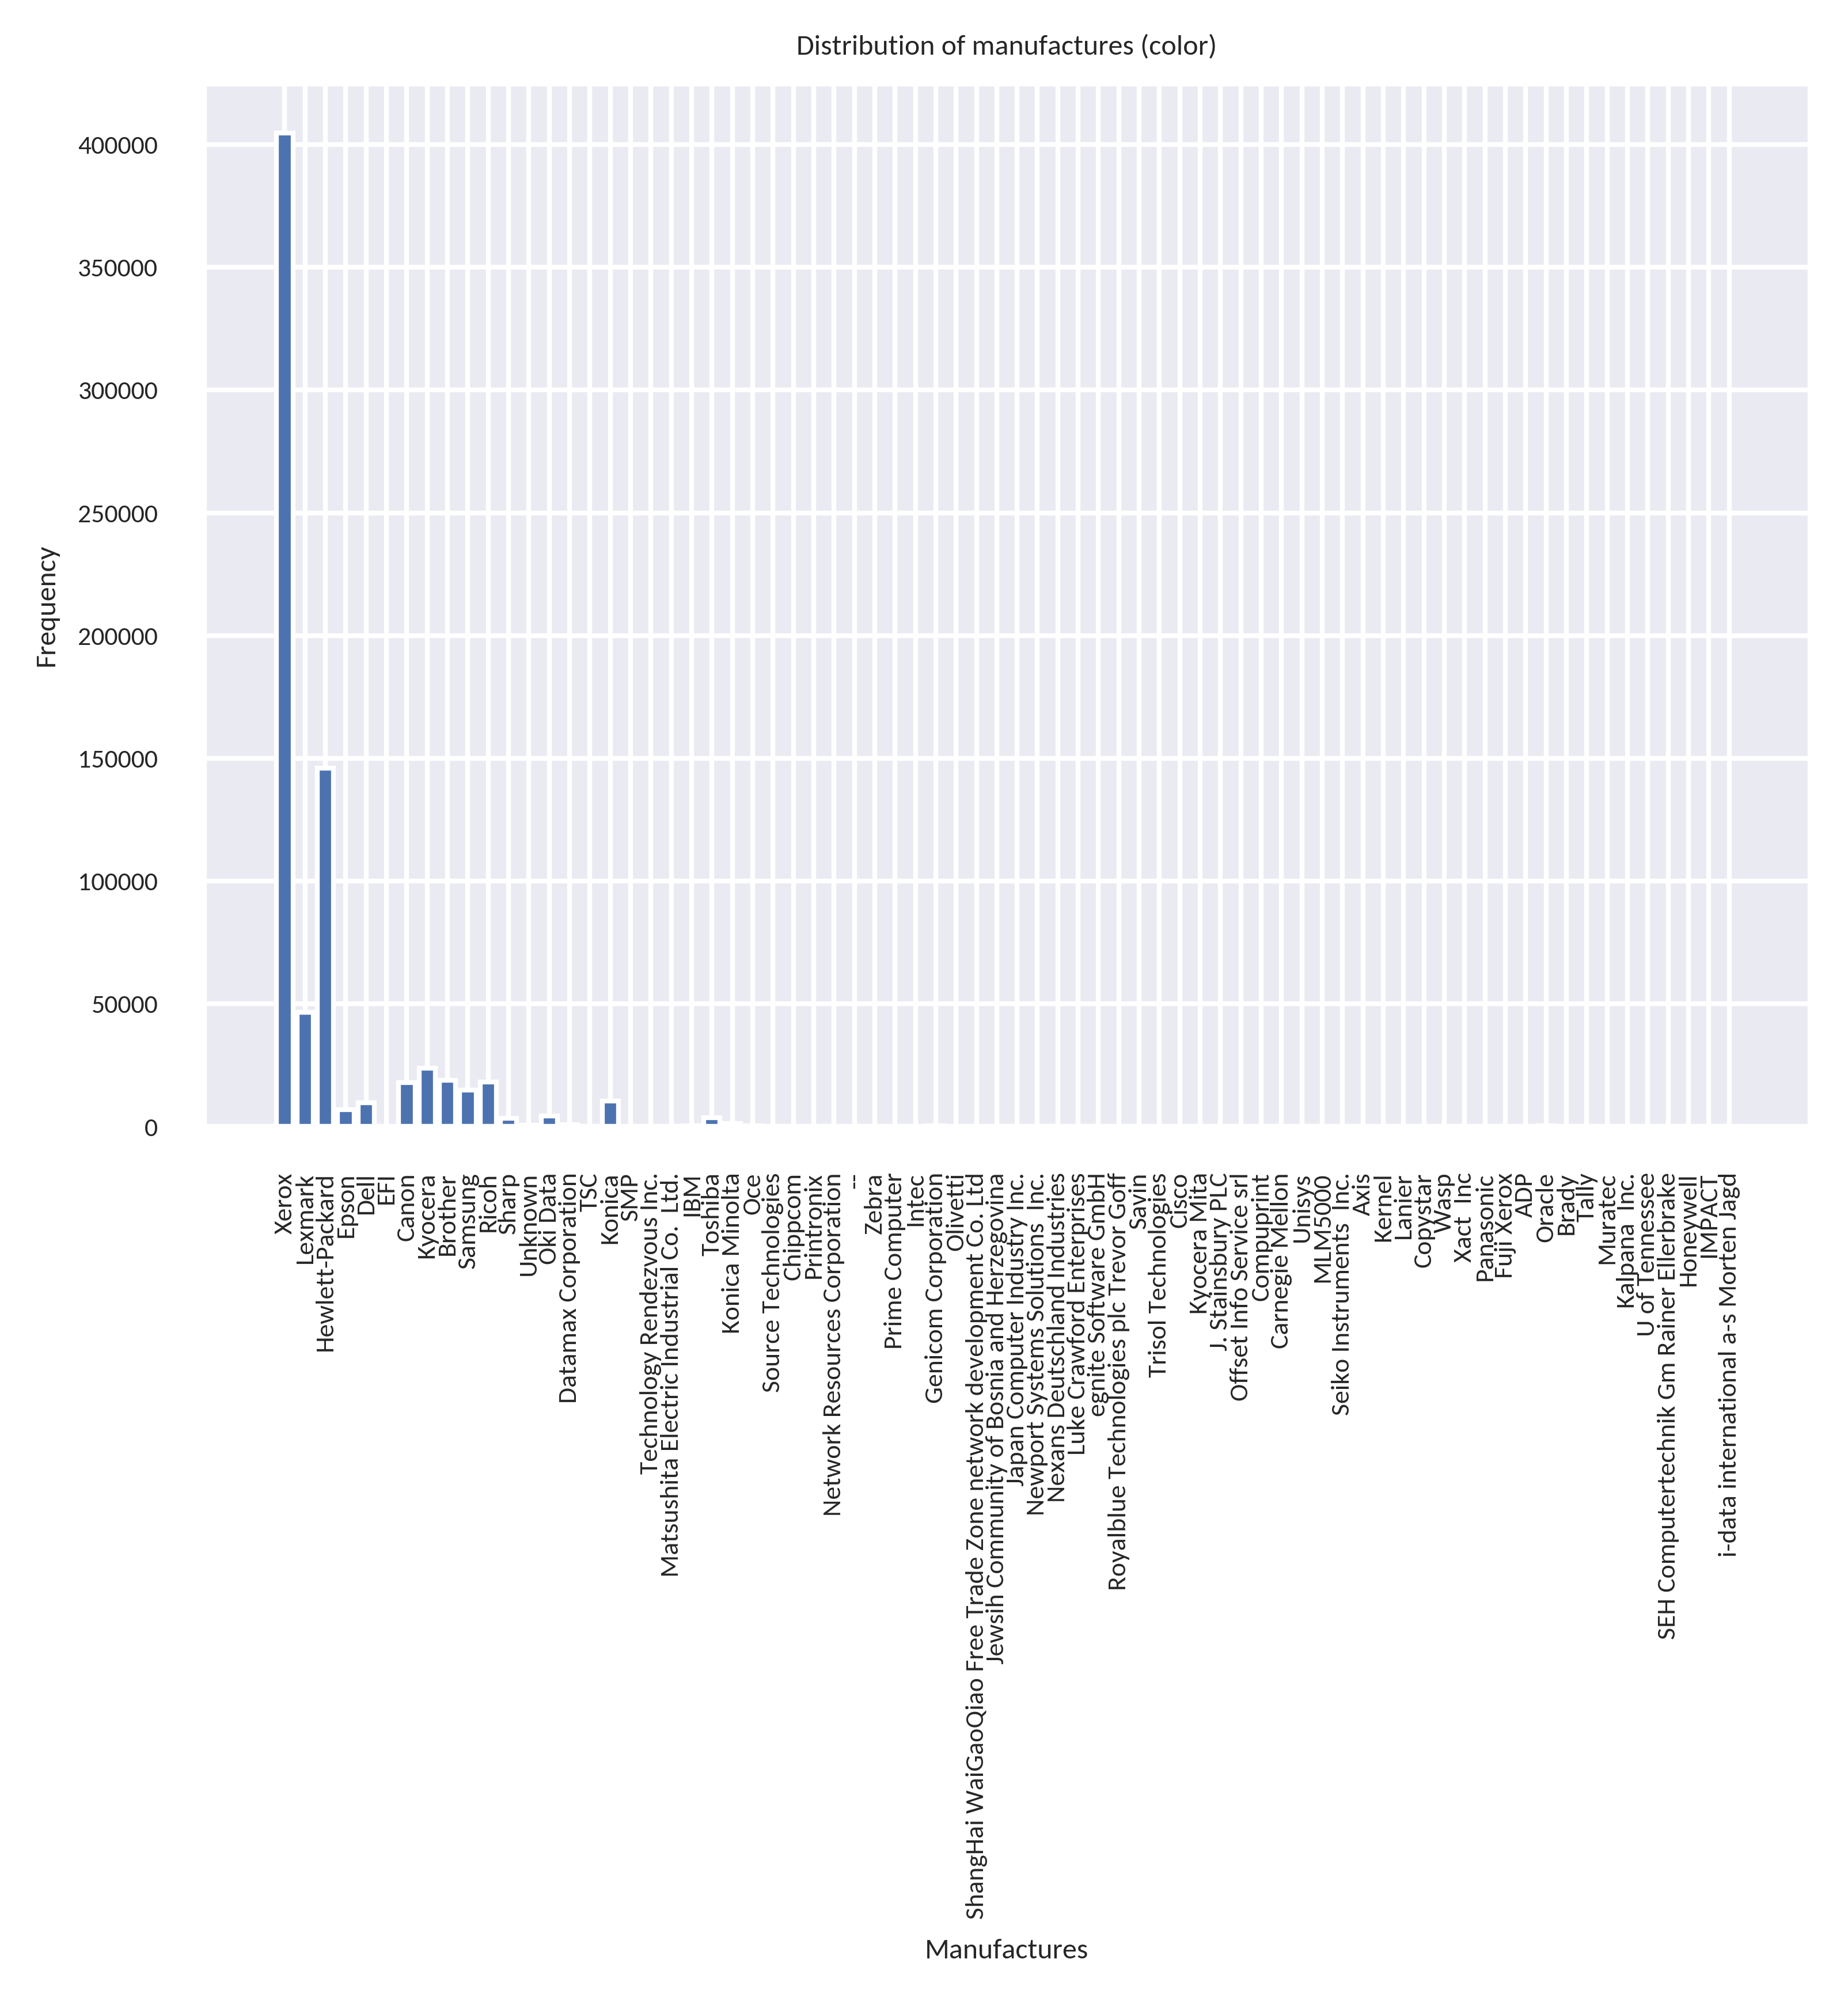

In [75]:
plt.bar(manuf_stats.keys(), [manuf_stats[i] for i in manuf_stats.keys()])
plt.xticks(rotation=90)
plt.title('Distribution of manufactures (color)')
plt.xlabel('Manufactures')
plt.ylabel('Frequency')
plt.show()

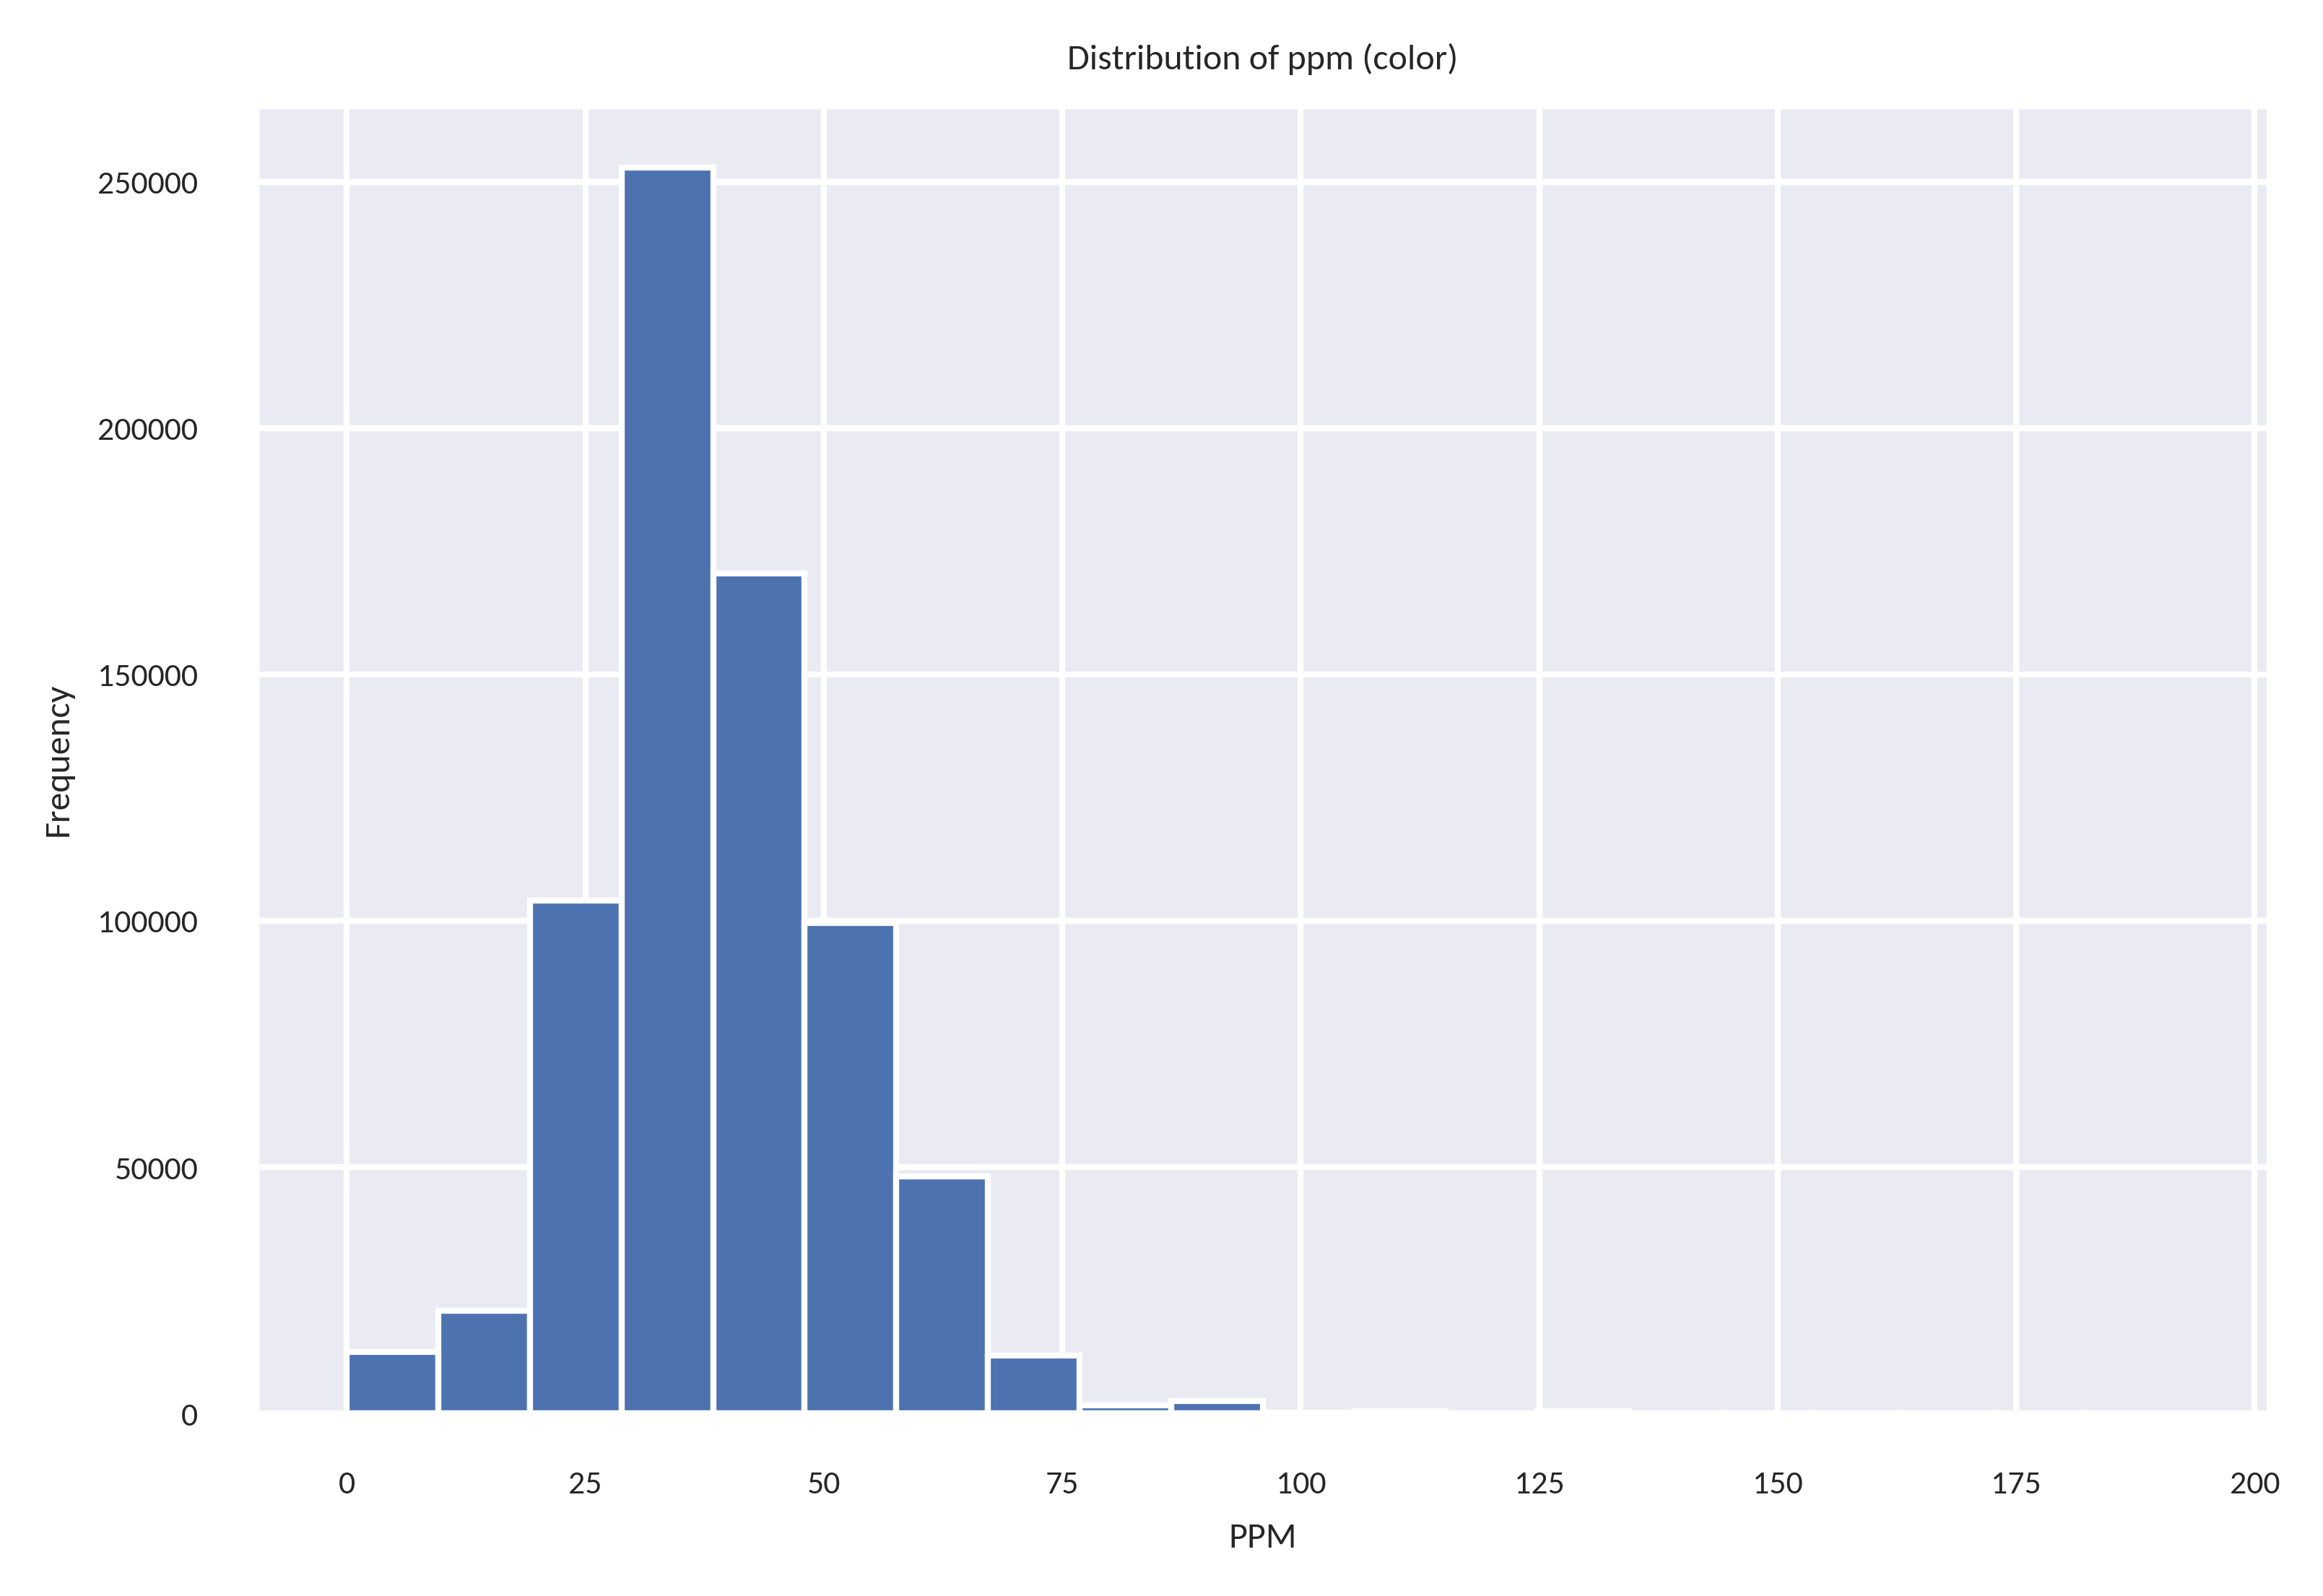

In [76]:
plt.hist(ppm.values[ppm.values < 200], bins = 20)
plt.title('Distribution of ppm (color)')
plt.xlabel('PPM')
plt.ylabel('Frequency')
plt.show()

# Further analysis on accounts with opportunities

In [22]:
r_data.head(5)

,dim_asset_sk,dim_acct_sk,month,BlackVolume,dim_asset_inscope,ColorVolume,dim_model_nm,dim_model_manf_nm,dim_model_manf_is_xerox,dim_loc_city,country_iso3,region,state,max_ppm,dim_model_ppm,classification
0,1687342,12,1,1310.0,1,0.0,workcentre 5655 copier/printer-pgpk,Xerox,1.0,Webster,USA,North America,NY,55.0,55.0,3
1,1687342,12,2,1760.0,1,0.0,workcentre 5655 copier/printer-pgpk,Xerox,1.0,Webster,USA,North America,NY,55.0,55.0,3
2,1824576,12,1,300.0,1,0.0,workcentre 5655 copier/printer-pgpk,Xerox,1.0,Webster,USA,North America,NY,55.0,55.0,3
3,1824576,12,2,67.0,1,0.0,workcentre 5655 copier/printer-pgpk,Xerox,1.0,Webster,USA,North America,NY,55.0,55.0,3
4,1868715,12,1,512.0,1,0.0,workcentre 5655 copier/printer-pgpk,Xerox,1.0,Webster,USA,North America,NY,55.0,55.0,3


In [9]:
bw_opp_data = r_data[r_data.dim_acct_sk.isin(true_bw_opp)]
col_opp_data = r_data[r_data.dim_acct_sk.isin(true_col_opp)]

In [71]:
def appendSlopes2(valid_in, color):
    valid_in_mon = valid_in.groupby(['dim_acct_sk', 'month', 'region', 'dim_model_manf_nm'])[color].sum().reset_index()
    valid_in_acct = valid_in_mon.groupby(['dim_acct_sk', 'region', 'dim_model_manf_nm'])[color].sum().reset_index()
    
    _ids = valid_in_acct.dim_acct_sk.values
    _locs = valid_in_acct.region.values
    _manufs = valid_in_acct.dim_model_manf_nm.values
    slopes = []
    p_val = []
    
#     count = 0
    for _id, _loc, _manuf in zip(_ids, _locs, _manufs):
#         count += 1
#         if count % 1000 == 0:
#             print(count)
        temp_df = valid_in_mon[(valid_in_mon.dim_acct_sk == _id) & (valid_in_mon.region == _loc) & (valid_in_mon.dim_model_manf_nm == _manuf)]
        response = np.zeros(12)
        response[temp_df['month']-1] = temp_df[color].values
        if np.any(response):
            response = (response - np.mean(response))/np.std(response)

    #     regr = linear_model.LinearRegression()
            lm = stats.linregress(np.arange(1,13), response)
            slopes.append(lm.slope)
            p_val.append(lm.pvalue)
        else:
            slopes.append(0)
            p_val.append(1)
#     print(valid_in_acct.shape[0])
#     print(len(slopes))
    valid_in_acct['slopes'] = slopes
    valid_in_acct['p-value'] = p_val

    return valid_in_acct

In [72]:
bw_asst = appendSlopes2(bw_opp_data, 'BlackVolume')
col_asst = appendSlopes2(col_opp_data, 'ColorVolume')
bw_asst.to_csv('/scratch/ywu82/Capstone/BW_Acct_with_loc_manuf_slopes.csv', index=False)
col_asst.to_csv('/scratch/ywu82/Capstone/COL_Acct_with_loc_manuf_slopes.csv', index=False)

In [73]:
bw_list = bw_asst[(bw_asst.slopes > 0) & (bw_asst['p-value'] < 0.05) & (bw_asst.BlackVolume > 1e6)].sort_values('slopes', ascending = False)
bw_list.shape

(83, 6)

In [74]:
bw_list.head(10)

,dim_acct_sk,region,dim_model_manf_nm,BlackVolume,slopes,p-value
458,2429,North America,Hewlett-Packard,2538830.0,0.275047,0.000002
401,2272,Africa,homeloandotcom,3364126.0,0.270952,0.000008
22,71,North America,Ricoh,4983409.0,0.263482,0.000041
1251,5713,Europe,Kyocera,3598515.0,0.258616,0.000093
675,3496,Europe,Ricoh,1369855.0,0.256613,0.000126
779,3610,Europe,Konica,7076389.0,0.254169,0.000177
1076,5170,South America,Ricoh,2109585.0,0.250336,0.000289
210,1847,North America,Ricoh,1701996.0,0.248170,0.000372
235,1866,North America,Xerox,20263262.0,0.244163,0.000576
300,2073,Europe,Lexmark,13711861.0,0.242101,0.000710
